### Import Custom Libraries

In [1]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# set up initial path to data
DATADIR = 'data'
game_id = 2 # let's look at sample match 2

### Read Events and Converts Metrica Units to Meters

In [2]:
# read in the event data
events = mio.read_event_data(DATADIR, game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

events = mio.to_metric_coordinates(events)

Reading team: home
Reading team: away


In [3]:
tracking_home.tail()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
141152,2,5646.08,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.8786,-24.22948,12.09788,...,NaN,NaN,-9.71278,24.17468,1.09392,-30.29672,-23.36028,9.04400,NaN,NaN
141153,2,5646.12,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.8786,-24.22948,12.09788,...,NaN,NaN,-9.71278,24.17468,1.09286,-30.34568,-23.31046,9.03176,NaN,NaN
141154,2,5646.16,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.8786,-24.22948,12.09788,...,NaN,NaN,-9.71278,24.17468,1.09074,-30.40348,-23.28714,9.02632,NaN,NaN
141155,2,5646.20,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.8786,-24.22948,12.09788,...,NaN,NaN,-9.71278,24.17468,1.08968,-30.45856,-23.25746,9.03992,NaN,NaN
141156,2,5646.24,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.8786,-24.22948,12.09788,...,NaN,NaN,-9.71278,24.17468,1.09074,-30.49528,-23.25110,9.18612,NaN,NaN


### Reverse Direction of Play 

In [4]:
# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

### Generate Match Clip from Events

In [ ]:
# Making a movie of the second home team goal
PLOTDIR = "movie"
#mviz.save_match_clip(tracking_home.iloc[73600:73600+500],tracking_away.iloc[73600:73600+500],PLOTDIR,fname='home_goal_2',include_player_velocities=False)

## Calculate and Plot Players Velocities

(<Figure size 864x576 with 1 Axes>, <Axes: >)

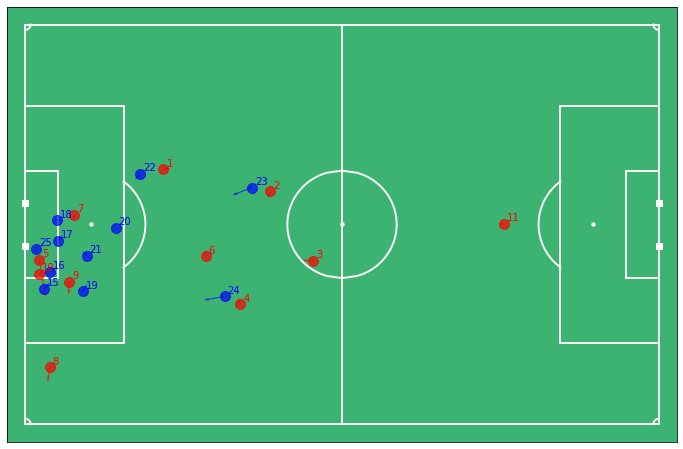

In [7]:
# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)
# **** NOTE *****
# if the lines above produce an error (happens for one version of numpy) change them to the lines below:
# ***************
#tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
#tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

# plot a random frame, plotting the player velocities using quivers
mviz.plot_frame( tracking_home.loc[10000], tracking_away.loc[10000], include_player_velocities=True, annotate=True)

### Calculates Physical Summary for all the Home Players: Minutes played, distances covered, etc...

In [8]:
# Create a Physical summary dataframe for home players
home_players = np.unique( [ c.split('_')[1] for c in tracking_home.columns if c[:4] == 'Home' ] ) # retrieve player number
home_summary = pd.DataFrame(index=home_players)

In [9]:
home_players # 11 is GK - 12, 13, 14 are subs 

array(['1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7',
       '8', '9'], dtype='<U2')

In [10]:
home_summary

""
1
10
11
12
13
14
2
3
4
5


### Minutes Played

In [11]:
# Calculate minutes played for each player
minutes = []
for player in home_players:
    # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Home_' + player + '_x' # use player x-position coordinate
    player_minutes = ( tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes.append( player_minutes )
home_summary['Minutes Played'] = minutes
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

In [12]:
home_summary

,Minutes Played
1,94.104000
11,94.104000
2,94.104000
3,94.104000
5,94.104000
6,94.104000
7,94.104000
9,94.104000
10,83.825333
8,70.740667


In [6]:
# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

### Distance Covered

In [13]:
# Calculate total distance covered for each player
distance = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_home[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance.append( player_distance )
home_summary['Distance [km]'] = distance

In [14]:
home_summary

,Minutes Played,Distance [km]
1,94.104000,10.369966
11,94.104000,5.203820
2,94.104000,9.845300
3,94.104000,9.546312
5,94.104000,11.909182
6,94.104000,11.535969
7,94.104000,11.068739
9,94.104000,9.765283
10,83.825333,8.959440
8,70.740667,9.012902


Text(0, 0.5, 'Distance covered [km]')

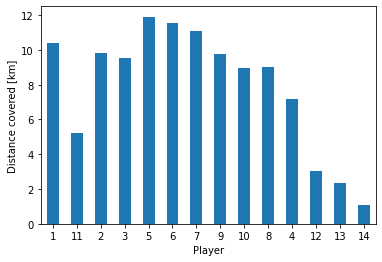

In [15]:
# make a simple bar chart of distance covered for each player
plt.subplots()
ax = home_summary['Distance [km]'].plot.bar(rot=0)
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [km]')

### Plot Starting Positions

(<Figure size 864x576 with 1 Axes>, <Axes: >)

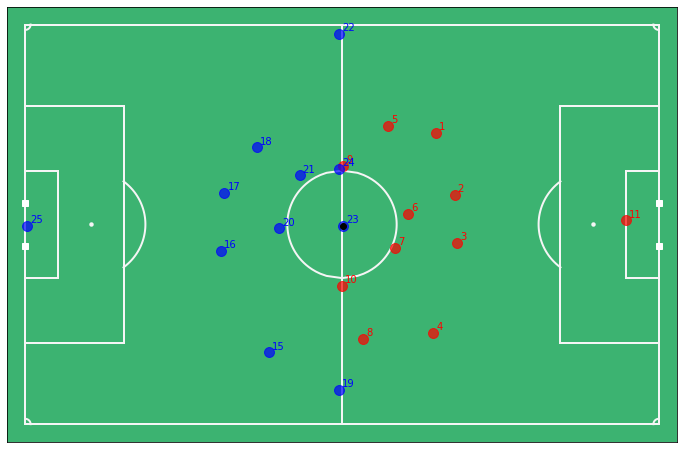

In [16]:
# plot positions at KO (to find out what position each player is playing)
mviz.plot_frame( tracking_home.loc[51], tracking_away.loc[51], include_player_velocities=False, annotate=True)

### Delving deeper into Distance Covered: Walking, Jogging, Running and Sprinting

In [17]:
# now calculate distance covered while: walking, joggings, running, sprinting
walking = []
jogging = []
running = []
sprinting = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 7 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 4) & (tracking_home[column] < 7), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[ tracking_home[column] >= 7, column].sum()/25./1000
    sprinting.append( player_distance )

In [22]:
home_summary['Walking [km]'] = walking
home_summary['Jogging [km]'] = jogging
home_summary['Running [km]'] = running
home_summary['Sprinting [km]'] = sprinting

home_summary

,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km],# sprints
1,94.104000,10.369966,3.701953,4.436083,2.149219,0.082712,5
11,94.104000,5.203820,4.394682,0.777765,0.029655,0.001718,0
2,94.104000,9.845300,4.085937,4.066061,1.612491,0.080811,3
3,94.104000,9.546312,4.178461,3.832849,1.382836,0.152166,8
5,94.104000,11.909182,3.583949,4.652462,3.519102,0.153669,8
6,94.104000,11.535969,3.385553,5.145440,2.829522,0.175454,7
7,94.104000,11.068739,3.606788,4.956883,2.324597,0.180470,9
9,94.104000,9.765283,4.428139,3.322470,1.863521,0.151153,7
10,83.825333,8.959440,3.858442,3.430553,1.404684,0.265760,13
8,70.740667,9.012902,2.604774,4.133859,2.183218,0.091051,6


Text(0, 0.5, 'Distance covered [m]')

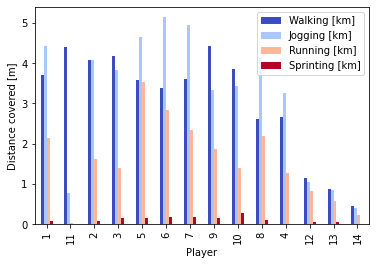

In [23]:
# make a clustered bar chart of distance covered for each player at each speed
ax = home_summary[['Walking [km]','Jogging [km]','Running [km]','Sprinting [km]']].plot.bar(colormap='coolwarm')
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [m]')

### Numbers of Sustained Sprints (maintaining a speed > 7 m/s for at least 1 second)
Identifies where each player sustained a speed of 7 m/s for at least 1 second. 

In [19]:
# sustained sprints: how many sustained sprints per match did each player complete? Defined as maintaining a speed > 7 m/s for at least 1 second
nsprints = []
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # trick here is to convolve speed with a window of size 'sprint_window', and find number of occassions that sprint was sustained for at least one window length
    # diff helps us to identify when the window starts
    player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
    nsprints.append( np.sum( player_sprints == 1 ) )
home_summary['# sprints'] = nsprints

In [21]:
home_summary

,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km],# sprints
1,94.104000,10.369966,3.701953,4.436083,2.149219,0.082712,5
11,94.104000,5.203820,4.394682,0.777765,0.029655,0.001718,0
2,94.104000,9.845300,4.085937,4.066061,1.612491,0.080811,3
3,94.104000,9.546312,4.178461,3.832849,1.382836,0.152166,8
5,94.104000,11.909182,3.583949,4.652462,3.519102,0.153669,8
6,94.104000,11.535969,3.385553,5.145440,2.829522,0.175454,7
7,94.104000,11.068739,3.606788,4.956883,2.324597,0.180470,9
9,94.104000,9.765283,4.428139,3.322470,1.863521,0.151153,7
10,83.825333,8.959440,3.858442,3.430553,1.404684,0.265760,13
8,70.740667,9.012902,2.604774,4.133859,2.183218,0.091051,6


### Identifies sprints trajectories for Player 10

Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done


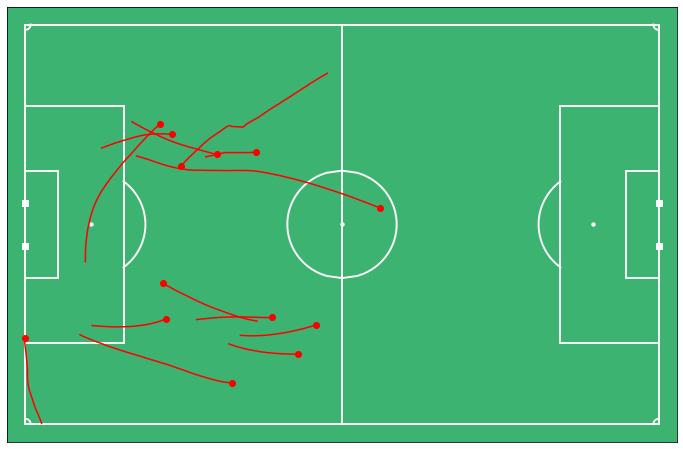

In [29]:
# Plot the trajectories for each of player 10's sprints
player = '10'
column = 'Home_' + player + '_speed' # spped
column_x = 'Home_' + player + '_x' # x position
column_y = 'Home_' + player + '_y' # y position
# same trick as before to find start and end indices of windows of size 'sprint_window' in which player speed was above the sprint_threshold
player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
player_sprints_start = np.where( player_sprints == 1 )[0] - int(sprint_window/2) + 1 # adding sprint_window/2 because of the way that the convolution is centred
player_sprints_end = np.where( player_sprints == -1 )[0] + int(sprint_window/2) + 1

# now plot all the sprints for Player 10
fig,ax = mviz.plot_pitch()
for s,e in zip(player_sprints_start,player_sprints_end):
    ax.plot(tracking_home[column_x].iloc[s],tracking_home[column_y].iloc[s],'ro') # start pos
    ax.plot(tracking_home[column_x].iloc[s:e+1],tracking_home[column_y].iloc[s:e+1],'r')

    
    # Save clips for each sprint
    mviz.save_match_clip(tracking_home.iloc[s:e+1],tracking_away.iloc[s:e+1],"movie",fname=f'sprint_{s}',include_player_velocities=False)